# How do starspot contrasts vary with stellar effective temperature in the JWST NIRSpec Clear/Prism bandpass?

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import ascii
import astropy.units as u

from astropy.modeling.blackbody import blackbody_lambda

Use starspot properties from Table 5 of [Berdyugina 2005](http://adsabs.harvard.edu/abs/2005LRSP....2....8B): 

In [2]:
table5 = ascii.read('data/berdyugina2005.csv')

Use the NIRSpec throughput curve from the JWST ETC: 

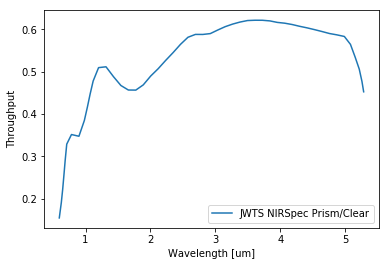

In [5]:
jwst_wl, jwst_throughput = np.loadtxt('../libra/data/etc/NIRSpec_S1600_prism_clear_throughput.csv', 
                                      delimiter=',', unpack=True)
jwst_wl *= u.um

plt.plot(jwst_wl, jwst_throughput, label='JWTS NIRSpec Prism/Clear')

plt.legend()
plt.gca().set(xlabel='Wavelength [um]', ylabel='Throughput');

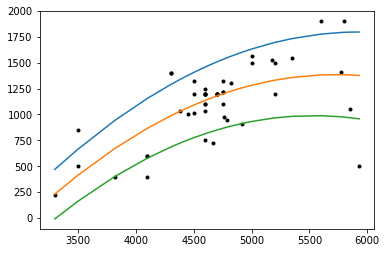

In [6]:
#plt.plot(table5['Teff K'], table5['deltaT K'], 'k.')

weighted_sunspot_temp_diff = (5770-5000)/5 + (5770-4200)*4/5

x = np.concatenate([table5['Teff K'].data.data, [5770]])
y = np.concatenate([table5['deltaT K'].data.data, 
                    [weighted_sunspot_temp_diff]]) 

x = x[y != 0]
y = y[y != 0]

yerr = 300 * np.ones_like(x)
yerr[-1] = 100

plt.plot(x, y, 'k.')

p, V = np.polyfit(x, y, 2, cov=True, w=1/yerr)
y_fit = np.polyval(p, x)

a0_err = np.sqrt(V[0, 0])
a1_err = np.sqrt(V[1, 1])
a2_err = np.sqrt(V[2, 2])

sort = np.argsort(x)
p_plus = p + np.array([a0_err, a1_err, a2_err])/20
p_minus = p - np.array([a0_err, a1_err, a2_err])/20
y_fit_plus = np.polyval(p_plus, x)
y_fit_minus = np.polyval(p_minus, x)

fit_params = [p_plus, p, p_minus]

x_range = np.linspace(x.min(), x.max(), 100)
np.savetxt('data/spot_temp_contrast.txt', 
           np.vstack([x_range, np.polyval(p, x_range)]).T)

plt.plot(x[sort], y_fit_plus[sort])
plt.plot(x[sort], y_fit[sort])
plt.plot(x[sort], y_fit_minus[sort])

plt.show()

Plot the spot and photosphere temperatures, along with the spot contrasts integrated in the NIRSpec Clear/Prism bandpass.

In [8]:
import sys
sys.path.insert(0, '../../mrspoc/')
from mrspoc import get_table_ms
from mrspoc.tgas import mamajek_path

mamajek = ascii.read(mamajek_path, format='commented_header')
effective_temperatures = {spt[:-1]: teff for spt, teff in 
                          zip(mamajek['SpT'].data, mamajek['Teff'].data)}

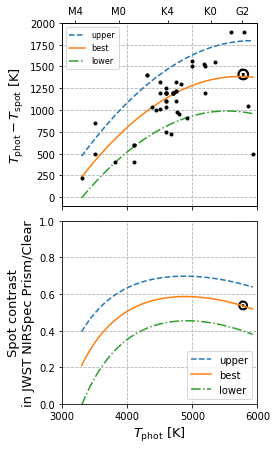

In [18]:
fontsize = 13

temp_phots = np.linspace(x.min(), x.max(), 50)

labels = ['upper', 'best', 'lower']
linestyles = ['--', '-', '-.']
teff_bounds = [3000, 6000]

fig, ax = plt.subplots(2, 1, figsize=(3.5, 7))

for fit_p, ls, label in zip(fit_params, linestyles, labels):
    
    get_temp_diff = lambda tphot: np.polyval(fit_p, tphot)
    ax[0].plot(temp_phots, get_temp_diff(temp_phots), label=label, ls=ls, lw=1.5)

    jwst_contrasts = []
    for temp in temp_phots: 
        phot_irr = blackbody_lambda(jwst_wl, temp)
        spot_temp = temp - get_temp_diff(temp)
        spot_irr = blackbody_lambda(jwst_wl, spot_temp)

        contrast = (1 - np.trapz(spot_irr*jwst_throughput*jwst_wl) / 
                    np.trapz(phot_irr*jwst_throughput*jwst_wl))
        jwst_contrasts.append(contrast)

    ax[1].plot(temp_phots, jwst_contrasts, ls=ls, lw=1.5, label=label)

    
ax[0].legend(loc='upper left', fontsize=8)
ax[1].legend(loc='lower right')
#ax[2].legend(loc='lower right')

ax[0].plot(x[:-1], y[:-1], 'k.')

ax0_upper = ax[0].twiny()
label_sptypes = ['M4', 'M0', 'K4', 'K0', 'G2']
label_teffs = [effective_temperatures[l] for l in label_sptypes]
ax0_upper.set_xlim(teff_bounds)
ax0_upper.set_xticks(label_teffs)
ax0_upper.set_xticklabels(label_sptypes)

sunspot_contrasts = []

for temp_diff, temp_phot, label in zip([5770-5000, 5770-4200], 
                                       [5770, 5770],
                                       ['umbra', 'penumbra']):

    phot_irr = blackbody_lambda(jwst_wl, temp_phot)
    spot_temp = temp_phot - temp_diff
    spot_irr = blackbody_lambda(jwst_wl, spot_temp)

    contrast = (1 - np.trapz(spot_irr*jwst_throughput*jwst_wl) / 
                np.trapz(phot_irr*jwst_throughput*jwst_wl))
    sunspot_contrasts.append(contrast.value)

    
ax[0].scatter(temp_phot, weighted_sunspot_temp_diff, 
              color='k', marker='$\odot$', 
              label='sun', s=150)
    
area_weighted_sunspot_contrast = np.dot(sunspot_contrasts, [1/5, 4/5])

ax[1].set_ylabel('Spot contrast\nin JWST NIRSpec Prism/Clear', fontsize=fontsize)
#ax[2].set_ylabel('Spot contrast\n(other missions)', fontsize=fontsize)
ax[-1].set_xlabel("$T_{\mathrm{phot}}$ [K]", fontsize=fontsize)
ax[0].set_ylabel("$T_{\mathrm{phot}} - T_{\mathrm{spot}}$ [K]", 
                 fontsize=fontsize)

xticks = np.arange(3000, 7000, 1000)

for axis in ax:
    axis.grid(ls='--')
    axis.set_xlim(teff_bounds)
    axis.set_xticks(xticks)
    
for i in range(2):
    ax[i].set_xticklabels([])

for i in range(1, 2):
    #ax[i].set_xticks(ax[0].get_xticks())
    ax[i].set_ylim([0, 1])
    ax[i].scatter(5770, area_weighted_sunspot_contrast, color='k', marker='$\odot$', 
                  label='sun', s=100)
ax[-1].set_xticklabels(xticks)
#ax[3].hist(table['Teff'], range=teff_bounds, color='k')
#ax[3].set_yticks([])
#ax[3].set_ylabel('Relative number\nof TGAS stars', fontsize=fontsize)
fig.subplots_adjust(hspace=0.08)
fig.savefig('contrasts.pdf', bbox_inches='tight')

*Upper*: The spot temperature contrasts scale quadratically with photosphere effective temperatures. The mean, area-weighted sunspot contrast is labeled $\odot$ (including both the umbra and penumbra).

*Lower*: Spot flux contrasts, approximated by integrating blackbody radiance curves with the temperatures of the photosphere and spot, convolved with the NIRSpec Prism/Clear throughput. The area-weighted mean sunspot contrast is 0.5, marked with $\odot$. 